<a href="https://colab.research.google.com/github/Akash-sahay/Computer-Vision-for-underwater-UAV/blob/main/Denoising_underwater_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps involved:
1) color correction
2) noise estimation
3) multi scale suppression
4) Non local patch filtering
5) Reconstruction
6) Final edge sharpening

**COLOR CORRECTION USING GREY WORLD ALGO AND COLOR COMPENSATION**

In [ ]:
from google.colab import files


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
#flag =0 for RB Compensation via green channel and flag=1 for red compensation via green channel

def compensate_RB(image, flag, alpha):
    # splitting the components to RGB
    imageR, imageG, imageB = image.split()

    # getting maximum and minimum pixel values
    minR, maxR = imageR.getextrema()
    minG, maxG = imageG.getextrema()
    minB, maxB = imageB.getextrema()

    # convert to array
    imageR = np.array(imageR, np.float64)
    imageG = np.array(imageG, np.float64)
    imageB = np.array(imageB, np.float64)

    x, y = image.size  # Corrected: image.size returns a tuple (width, height)

    # normalizing pixel values to 0 to 1
    for i in range(0, y):
        for j in range(0, x):
            imageR[i, j] = (imageR[i, j] - minR) / (maxR - minR)
            imageG[i, j] = (imageG[i, j] - minG) / (maxG - minG)
            imageB[i, j] = (imageB[i, j] - minB) / (maxB - minB)

    # getting mean of each channel
    meanR = np.mean(imageR)
    meanG = np.mean(imageG)
    meanB = np.mean(imageB)

    # compensate red and blue channel
    if flag == 0:
        for i in range(y):
            for j in range(x):
                imageR[i][j] = int((imageR[i][j] + (meanG - meanR) * (1 - np.exp(-alpha * imageR[i][j])) * imageG[i][j]) * maxR)
                imageB[i][j] = int((imageB[i][j] + (meanG - meanB) * (1 - np.exp(-alpha * imageB[i][j])) * imageG[i][j]) * maxB)

    # compensate red channel only
    if flag == 1:
        for i in range(y):
            for j in range(x):
                imageR[i][j] = int((imageR[i][j] + (meanG - meanR) * (1 - imageR[i][j]) * imageG[i][j]) * maxR)

    # scaling the pixel values back to original range
    for i in range(0, y):
        for j in range(0, x):
            imageG[i][j] = int(imageG[i][j] * maxG)
            imageB[i][j] = int(imageB[i][j] * maxB)

    # create the compensated image
    compensatedIM = np.zeros((y, x, 3), dtype="uint8")
    compensatedIM[:, :, 0] = imageR
    compensatedIM[:, :, 1] = imageG
    compensatedIM[:, :, 2] = imageB
    compensatedIM = Image.fromarray(compensatedIM)

    return compensatedIM

In [ ]:
#White balancing using grey world algorithm
def gray_world(image):
  imageR, imageG, imageB = image.split()
  #form a grayscale image
  imageGray = image.convert('L')

  # convert to array
  imageR = np.array(imageR, np.float64)
  imageG = np.array(imageG, np.float64)
  imageB = np.array(imageB, np.float64)
  imageGray = np.array(imageGray, np.float64)

  x, y = image.size
  meanR = np.mean(imageR)
  meanG = np.mean(imageG)
  meanB = np.mean(imageB)
  meanGray = np.mean(imageGray)
  #Gray world algorithm
  for i in range(0, y):
    for j in range(0, x):
      imageR[i][j] = int(imageR[i][j] * (meanGray / meanR))
      imageG[i][j] = int(imageG[i][j] * (meanGray / meanG))
      imageB[i][j] = int(imageB[i][j] * (meanGray / meanB))
  #create white balanced image
  whitebalancedIM = np.zeros((y,x,3), dtype="uint8")
  whitebalancedIM[:, :, 0] = imageR
  whitebalancedIM[:, :, 1] = imageG
  whitebalancedIM[:, :, 2] = imageB
  whitebalancedIM = Image.fromarray(whitebalancedIM)
  return whitebalancedIM


In [ ]:
# Upload the image
uploaded = files.upload()

# Load the image
image_path = list(uploaded.keys())[0]
image = Image.open(image_path)

Saving underwater image.jpg to underwater image.jpg


In [ ]:
image.size

(1920, 1202)

**Histogram Analysis to find which color should be compensated to what extent.**

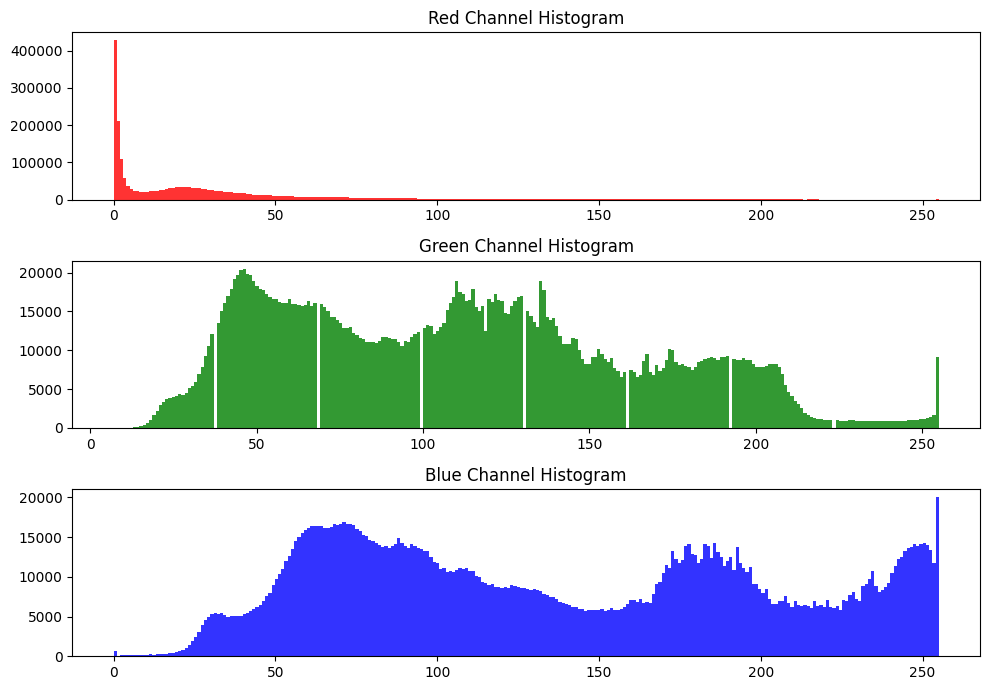

In [ ]:

# Split the image into individual B, G, R channels
R, G, B = image.split()
# Convert the channels to NumPy arrays
B = np.array(B)
G = np.array(G)
R = np.array(R)
# Plot the histograms
plt.figure(figsize=(10, 7))
# Red channel histogram
plt.subplot(3, 1, 1)
plt.hist(R.ravel(), bins=256, color='red', alpha=0.8)
plt.title('Red Channel Histogram')

# Green channel histogram
plt.subplot(3, 1, 2)
plt.hist(G.ravel(), bins=256, color='green', alpha=0.8)
plt.title('Green Channel Histogram')

# Blue channel histogram
plt.subplot(3, 1, 3)
plt.hist(B.ravel(), bins=256, color='blue', alpha=0.8)
plt.title('Blue Channel Histogram')

plt.tight_layout()
plt.show()

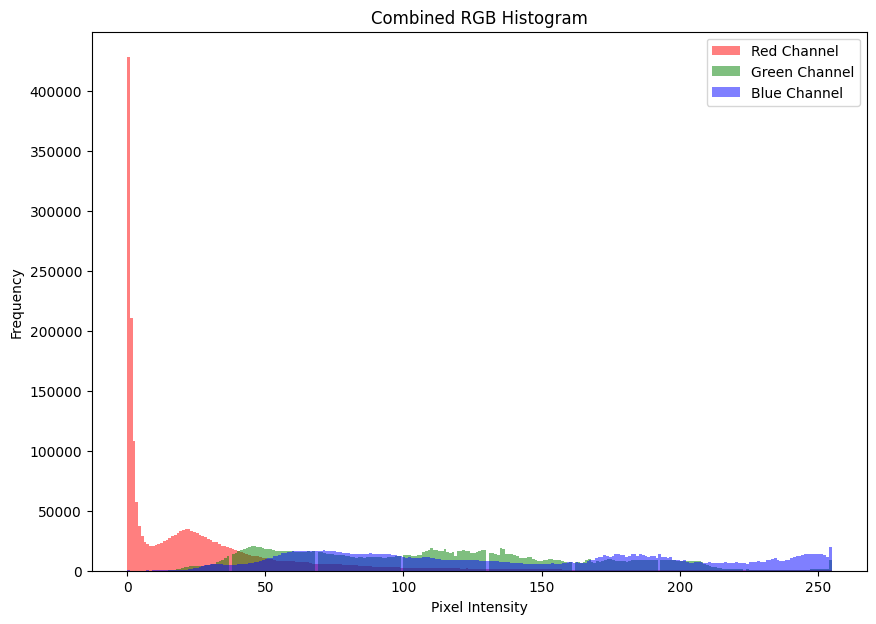

In [ ]:
# Plot the combined histogram
plt.figure(figsize=(10, 7))

plt.hist(R.ravel(), bins=256, color='red', alpha=0.5, label='Red Channel')
plt.hist(G.ravel(), bins=256, color='green', alpha=0.5, label='Green Channel')
plt.hist(B.ravel(), bins=256, color='blue', alpha=0.5, label='Blue Channel')

plt.title('Combined RGB Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compensate_color_exponential(image, alpha_R=1.2, alpha_G=0.2, alpha_B=0.2, depth_map=None):
    """
    Compensates for color attenuation in an underwater image.

    Parameters:
    - image: Input underwater image (in BGR format).
    - alpha_R, alpha_G, alpha_B: Attenuation coefficients for Red, Green, and Blue channels respectively.
    - depth_map: Estimated depth map of the image (optional). If None, a uniform depth will be assumed.

    Returns:
    - compensated_image: Color compensated image.
    """
    # Split the image into individual B, G, R channels
    B, G, R = cv2.split(image)

    # Get image dimensions
    height, width = image.shape[:2]

    # If no depth map is provided, assume a uniform depth for simplicity
    if depth_map is None:
        depth_map = np.ones((height, width)) * 0.5  # Assuming a constant depth of 0.5

    # Apply the compensation formula for each channel
    compensated_R = R * np.exp(alpha_R * depth_map)
    compensated_G = G * np.exp(alpha_G * depth_map)
    compensated_B = B * np.exp(alpha_B * depth_map)

    # Clip the values to the valid range [0, 255] and convert back to uint8
    compensated_R = np.clip(compensated_R, 0, 255).astype(np.uint8)
    compensated_G = np.clip(compensated_G, 0, 255).astype(np.uint8)
    compensated_B = np.clip(compensated_B, 0, 255).astype(np.uint8)

    # Merge the compensated channels back together
    compensated_image = cv2.merge([compensated_B, compensated_G, compensated_R])

    return compensated_image

# Load the image (replace 'underwater_image.jpg' with your uploaded file name)
image = cv2.imread(list(uploaded.keys())[0])

# Perform color compensation
compensated_image_exponential = compensate_color_exponential(image)

# Convert BGR to RGB for displaying with matplotlib
compensated_image_rgb_exponential = cv2.cvtColor(compensated_image_exponential, cv2.COLOR_BGR2RGB)
original_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

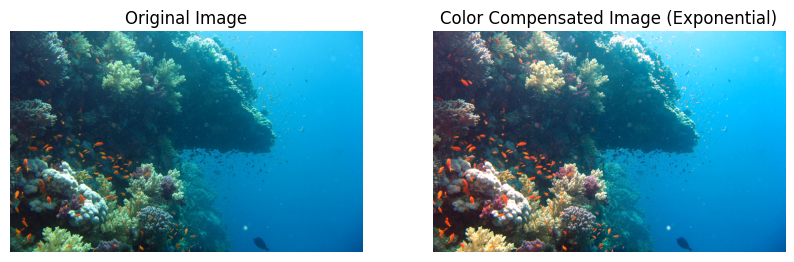

In [ ]:
# Display the original and compensated images side by side using matplotlib
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(compensated_image_rgb_exponential)
plt.title('Color Compensated Image (Exponential)')
plt.axis('off')

plt.show()

**Different Channel Analysis Methods to find the least degraded Channel**

Method-1 (Entropy Analysis)

In [ ]:
from skimage.filters import sobel
from scipy.stats import entropy
# Calculate entropy for each channel
entropy_r = entropy(R.ravel(), base=2)
entropy_g = entropy(G.ravel(), base=2)
entropy_b = entropy(B.ravel(), base=2)
print(f"Shannon Entropy  for Red channel: {entropy_r}")
print(f"Shannon Entropy  for Green channel: {entropy_g}")
print(f"Shannon Entropy  for Blue channel: {entropy_b}")

Shannon Entropy  for Red channel: 20.079028587396788
Shannon Entropy  for Green channel: 20.968279518353373
Shannon Entropy  for Blue channel: 20.96046911923177


In [ ]:
def renyi_entropy(channel, alpha=2):
    # Flatten the image channel to a 1D array
    values, counts = np.unique(channel, return_counts=True)

    # Normalize the counts to get probabilities
    probs = counts / np.sum(counts)

    if alpha == 1:
        # If alpha is 1, calculate Shannon entropy instead
        entropy = -np.sum(probs * np.log2(probs))
    else:
        # Calculate Rényi entropy for the given alpha
        entropy = 1 / (1 - alpha) * np.log2(np.sum(probs**alpha))

    return entropy

In [ ]:
# Calculate Rényi entropy for each channel
alpha_value = 2  # Set your desired alpha value here
entropy_R = renyi_entropy(R, alpha=alpha_value)
entropy_G = renyi_entropy(G, alpha=alpha_value)
entropy_B = renyi_entropy(B, alpha=alpha_value)
print(f"Rényi Entropy (alpha={alpha_value}) for Red channel: {entropy_R}")
print(f"Rényi Entropy (alpha={alpha_value}) for Green channel: {entropy_G}")
print(f"Rényi Entropy (alpha={alpha_value}) for Blue channel: {entropy_B}")


Rényi Entropy (alpha=2) for Red channel: 4.290493204042324
Rényi Entropy (alpha=2) for Green channel: 7.481780494016152
Rényi Entropy (alpha=2) for Blue channel: 7.68567156329715


**Other Methods**
2.  Histogram Analysis
3.  Visual Inspection
4. Signal to Noise Ratio (SNR) of each channel



**Signal to Noise Ratio**

In [ ]:
# Calculate the standard deviation (noise level) for each channel
std_dev_R = np.std(R)
std_dev_G = np.std(G)
std_dev_B = np.std(B)

# Calculate the mean intensity for each channel
mean_R = np.mean(R)
mean_G = np.mean(G)
mean_B = np.mean(B)

# Calculate the Signal-to-Noise Ratio (SNR) for each channel
snr_R = mean_R / std_dev_R
snr_G = mean_G / std_dev_G
snr_B = mean_B / std_dev_B

print(f"Red Channel - Standard Deviation (Noise Level): {std_dev_R}, Mean: {mean_R}, SNR: {snr_R}")
print(f"Green Channel - Standard Deviation (Noise Level): {std_dev_G}, Mean: {mean_G}, SNR: {snr_G}")
print(f"Blue Channel - Standard Deviation (Noise Level): {std_dev_B}, Mean: {mean_B}, SNR: {snr_B}")


Red Channel - Standard Deviation (Noise Level): 39.113958918281945, Mean: 28.936418035912368, SNR: 0.739797730430898
Green Channel - Standard Deviation (Noise Level): 53.49035058345357, Mean: 111.53260364669994, SNR: 2.0850976378008794
Blue Channel - Standard Deviation (Noise Level): 66.74340895343897, Mean: 137.47217311425402, SNR: 2.0597115920488314


**Histogram Matching Method**

In [ ]:
from skimage.exposure import match_histograms

# Assuming Green is the least degraded channel
imageR_adjusted = match_histograms(R, G)
imageB_adjusted = match_histograms(B, G)
compensated_image = np.stack([imageR_adjusted, G, imageB_adjusted], axis=-1).astype(np.uint8)
compensated_image = Image.fromarray(compensated_image)

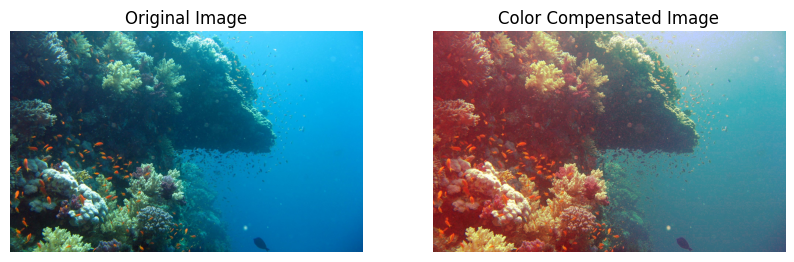

In [ ]:
# Display the original and compensated images side by side using matplotlib
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(compensated_image)
plt.title('Color Compensated Image')
plt.axis('off')

plt.show()

Using some other functions to achieve color compensation:
A) Hyperbolic Functions
B) Logarithmic Functions
C) Combination of logarithmic anf hyperbolic functions

In [ ]:
def compensate_color_hyperbolic(image, alpha_R=1.2, alpha_G=0.2, alpha_B=0.2, depth_map=None):
    """
    Compensates for color attenuation in an underwater image.

    Parameters:
    - image: Input underwater image (in BGR format).
    - alpha_R, alpha_G, alpha_B: Attenuation coefficients for Red, Green, and Blue channels respectively.
    - depth_map: Estimated depth map of the image (optional). If None, a uniform depth will be assumed.

    Returns:
    - compensated_image: Color compensated image.
    """
    # Split the image into individual B, G, R channels
    B, G, R = cv2.split(image)

    # Get image dimensions
    height, width = image.shape[:2]

    # If no depth map is provided, assume a uniform depth for simplicity
    if depth_map is None:
        depth_map = np.ones((height, width)) * 0.5  # Assuming a constant depth of 0.5

    # Apply the compensation formula for each channel
    compensated_R = R * np.tanh(alpha_R * depth_map)
    compensated_G = G * np.tanh(alpha_G * depth_map)
    compensated_B = B * np.tanh(alpha_B * depth_map)

    # Clip the values to the valid range [0, 255] and convert back to uint8
    compensated_R = np.clip(compensated_R, 0, 255).astype(np.uint8)
    compensated_G = np.clip(compensated_G, 0, 255).astype(np.uint8)
    compensated_B = np.clip(compensated_B, 0, 255).astype(np.uint8)

    # Merge the compensated channels back together
    compensated_image = cv2.merge([compensated_B, compensated_G, compensated_R])

    return compensated_image

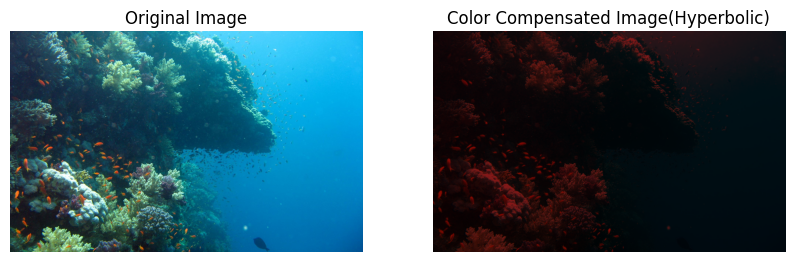

In [ ]:
# Load the image (replace 'underwater_image.jpg' with your uploaded file name)
image = cv2.imread(list(uploaded.keys())[0])

# Perform color compensation
compensated_image_hyperbolic = compensate_color_hyperbolic(image)

# Convert BGR to RGB for displaying with matplotlib
compensated_image_rgb_hyperbolic = cv2.cvtColor(compensated_image_hyperbolic, cv2.COLOR_BGR2RGB)
original_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Display the original and compensated images side by side using matplotlib
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(compensated_image_rgb_hyperbolic)
plt.title('Color Compensated Image(Hyperbolic)')
plt.axis('off')

plt.show()


In [ ]:
def compensate_color_logarithmic(image, alpha_R=1.1, alpha_G=0.1, alpha_B=0.1, depth_map=None):
    """
    Compensates for color attenuation in an underwater image.

    Parameters:
    - image: Input underwater image (in BGR format).
    - alpha_R, alpha_G, alpha_B: Attenuation coefficients for Red, Green, and Blue channels respectively.
    - depth_map: Estimated depth map of the image (optional). If None, a uniform depth will be assumed.

    Returns:
    - compensated_image: Color compensated image.
    """
    # Split the image into individual B, G, R channels
    B, G, R = cv2.split(image)

    # Get image dimensions
    height, width = image.shape[:2]

    # If no depth map is provided, assume a uniform depth for simplicity
    if depth_map is None:
        depth_map = np.ones((height, width)) * 0.5  # Assuming a constant depth of 0.5

    # Apply the compensation formula for each channel
    compensated_R = R * np.log(1+alpha_R*R* depth_map)
    compensated_G = G * np.log(1+alpha_G*G* depth_map)
    compensated_B = B * np.log(1+alpha_B*B* depth_map)

    # Clip the values to the valid range [0, 255] and convert back to uint8
    compensated_R = np.clip(compensated_R, 0, 255).astype(np.uint8)
    compensated_G = np.clip(compensated_G, 0, 255).astype(np.uint8)
    compensated_B = np.clip(compensated_B, 0, 255).astype(np.uint8)

    # Merge the compensated channels back together
    compensated_image = cv2.merge([compensated_B, compensated_G, compensated_R])

    return compensated_image

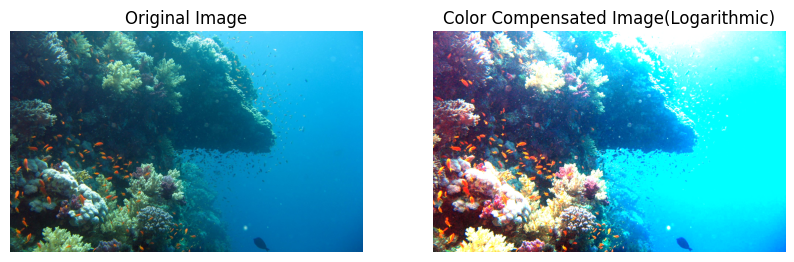

In [ ]:
# Perform color compensation
compensated_image_logarithmic = compensate_color_logarithmic(image)
# Convert BGR to RGB for displaying with matplotlib
compensated_image_rgb_logarithmic = cv2.cvtColor(compensated_image_logarithmic, cv2.COLOR_BGR2RGB)
original_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Display the original and compensated images side by side using matplotlib
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(compensated_image_rgb_logarithmic)
plt.title('Color Compensated Image(Logarithmic)')
plt.axis('off')

plt.show()

In [ ]:
def compensate_color_linear(image, alpha_R=1.2, alpha_G=0.2, alpha_B=0.2, depth_map=None):
    """
    Compensates for color attenuation in an underwater image using a linear function.

    Parameters:
    - image: Input underwater image (in BGR format).
    - alpha_R, alpha_G, alpha_B: Attenuation coefficients for Red, Green, and Blue channels respectively.
    - depth_map: Estimated depth map of the image (optional). If None, a uniform depth will be assumed.

    Returns:
    - compensated_image: Color compensated image.
    """
    # Split the image into individual B, G, R channels
    B, G, R = cv2.split(image)

    # Get image dimensions
    height, width = image.shape[:2]

    # If no depth map is provided, assume a uniform depth for simplicity
    if depth_map is None:
        depth_map = np.ones((height, width)) * 0.5  # Assuming a constant depth of 0.5

    # Apply the linear compensation formula for each channel
    compensated_R = R + alpha_R * R * depth_map
    compensated_G = G + alpha_G * G * depth_map
    compensated_B = B + alpha_B * B * depth_map

    # Clip the values to the valid range [0, 255] and convert back to uint8
    compensated_R = np.clip(compensated_R, 0, 255).astype(np.uint8)
    compensated_G = np.clip(compensated_G, 0, 255).astype(np.uint8)
    compensated_B = np.clip(compensated_B, 0, 255).astype(np.uint8)

    # Merge the compensated channels back together
    compensated_image = cv2.merge([compensated_B, compensated_G, compensated_R])

    return compensated_image


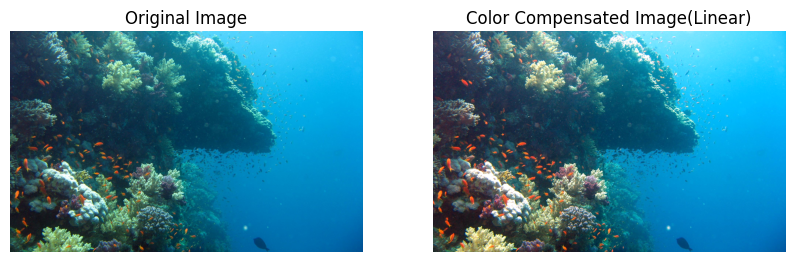

In [ ]:
# Perform color compensation
compensated_image_linear = compensate_color_linear(image)
# Convert BGR to RGB for displaying with matplotlib
compensated_image_rgb_linear = cv2.cvtColor(compensated_image_linear, cv2.COLOR_BGR2RGB)
original_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Display the original and compensated images side by side using matplotlib
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(compensated_image_rgb_linear)
plt.title('Color Compensated Image(Linear)')
plt.axis('off')

plt.show()

In [ ]:
#CALCULATING SNR OF THE IMAGES
def calculate_snr(image):
    """
    Function to calculate the Signal-to-Noise Ratio (SNR) of an image.

    Parameters:
    - image: Input image (grayscale or color).

    Returns:
    - snr: Signal-to-Noise Ratio (SNR) value.
    """

    # Convert to grayscale if image is in color
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image

    # Compute the mean (signal) and the standard deviation (noise)
    mean_signal = np.mean(image_gray)  # Mean intensity value (signal)
    std_noise = np.std(image_gray)     # Standard deviation (noise)

    # Calculate SNR
    snr = mean_signal / std_noise

    return snr

In [ ]:
calculate_snr(compensated_image_rgb_exponential)


2.1831304881989624

In [ ]:
calculate_snr(compensated_image_rgb_hyperbolic)

1.9710877794826822

In [ ]:
calculate_snr(compensated_image_rgb_logarithmic)

2.3760428987499647

In [ ]:
calculate_snr(original_image_rgb)

2.140150202389161

In [ ]:
calculate_snr(compensated_image_rgb_linear)

2.175844232034999

In [ ]:
def gray_world_balance(image):
    """
    Applies gray world color balancing to the input image.

    Parameters:
    - image: Input BGR image to be balanced.

    Returns:
    - balanced_image: Color-balanced image.
    """
    # Split the image into B, G, R channels
    B, G, R = cv2.split(image)

    # Calculate the mean values of the B, G, R channels
    mean_B = np.mean(B)
    mean_G = np.mean(G)
    mean_R = np.mean(R)

    # Calculate the overall average mean
    mean_gray = (mean_B + mean_G + mean_R) / 3

    # Scaling factors for each channel
    scale_B = mean_gray / mean_B
    scale_G = mean_gray / mean_G
    scale_R = mean_gray / mean_R

    # Apply the scaling factors to each channel
    balanced_B = np.clip(B * scale_B, 0, 255).astype(np.uint8)
    balanced_G = np.clip(G * scale_G, 0, 255).astype(np.uint8)
    balanced_R = np.clip(R * scale_R, 0, 255).astype(np.uint8)

    # Merge the balanced channels back together
    balanced_image = cv2.merge([balanced_B, balanced_G, balanced_R])

    return balanced_image


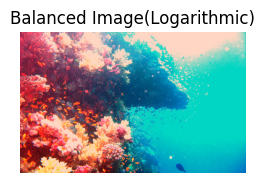

In [ ]:
# Apply gray world balancing
balanced_image_logarithmic = gray_world_balance(compensated_image_logarithmic)

# Convert BGR to RGB for displaying with matplotlib
balanced_image_rgb_logarithmic = cv2.cvtColor(balanced_image_logarithmic, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 2)
plt.imshow(balanced_image_rgb)
plt.title('Balanced Image(Logarithmic)')
plt.axis('off')

plt.show()

In [ ]:
calculate_snr(balanced_image_rgb_logarithmic)

2.4837966449609414

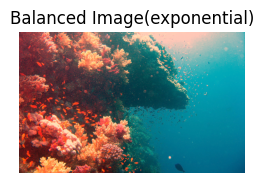

In [ ]:
# Apply gray world balancing
balanced_image_exponential = gray_world_balance(compensated_image_exponential)

# Convert BGR to RGB for displaying with matplotlib
balanced_image_rgb_exponential = cv2.cvtColor(balanced_image_exponential, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 2)
plt.imshow(balanced_image_rgb_exponential)
plt.title('Balanced Image(exponential)')
plt.axis('off')

plt.show()

In [ ]:
calculate_snr(balanced_image_rgb_exponential)

2.245612779449498

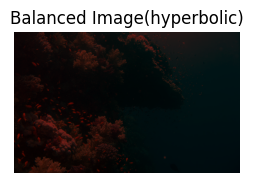

In [ ]:
# Apply gray world balancing
balanced_image_hyperbolic = gray_world_balance(compensated_image_hyperbolic)

# Convert BGR to RGB for displaying with matplotlib
balanced_image_rgb_hyperbolic = cv2.cvtColor(balanced_image_hyperbolic, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 2)
plt.imshow(balanced_image_rgb_hyperbolic)
plt.title('Balanced Image(hyperbolic)')
plt.axis('off')

plt.show()

In [ ]:
calculate_snr(balanced_image_rgb_hyperbolic)

1.8976846989481115

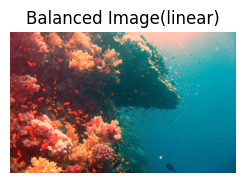

In [ ]:
# Apply gray world balancing
balanced_image_linear = gray_world_balance(compensated_image_linear)

# Convert BGR to RGB for displaying with matplotlib
balanced_image_rgb_linear = cv2.cvtColor(balanced_image_linear, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 2)
plt.imshow(balanced_image_rgb_linear)
plt.title('Balanced Image(linear)')
plt.axis('off')

plt.show()

In [ ]:
calculate_snr(balanced_image_rgb_linear)

2.2394439301165288

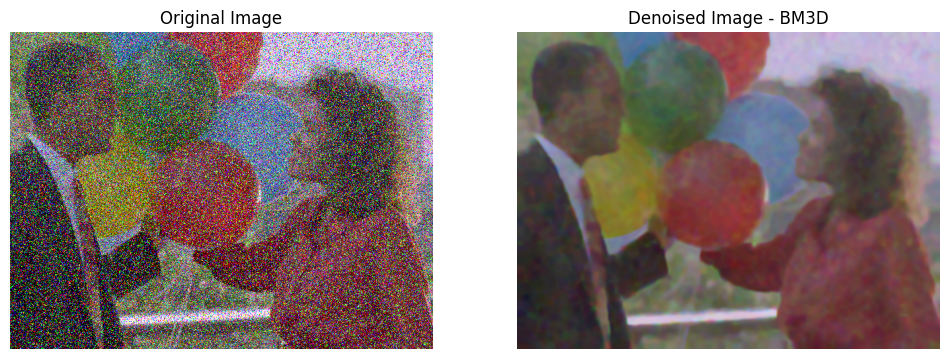

In [ ]:
!pip install bm3d
import cv2
import numpy as np
from bm3d import bm3d, BM3DStages
import matplotlib.pyplot as plt

def denoise_image_bm3d(image_path, sigma_psd=0.5):
    """
    Denoise an RGB image using the BM3D algorithm.

    Parameters:
    - image_path: Path to the input image.
    - sigma_psd: Standard deviation of the noise to be removed. Default is 0.1.

    Returns:
    - denoised_image: The denoised image as a NumPy array.
    """
    # Load the image in color mode (BGR format)
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        print("Error: Could not load image. Please check the file path.")
        return None

    # Convert image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Split the image into its RGB channels
    R, G, B = cv2.split(image_rgb)

    # Normalize each channel to the range [0, 1]
    R = R / 255.0
    G = G / 255.0
    B = B / 255.0

    # Apply BM3D denoising to each channel
    denoised_R = bm3d(R, sigma_psd=sigma_psd, stage_arg=BM3DStages.ALL_STAGES)
    denoised_G = bm3d(G, sigma_psd=sigma_psd, stage_arg=BM3DStages.ALL_STAGES)
    denoised_B = bm3d(B, sigma_psd=sigma_psd, stage_arg=BM3DStages.ALL_STAGES)

    # Convert each channel back to the 8-bit format
    denoised_R = (denoised_R * 255).astype(np.uint8)
    denoised_G = (denoised_G * 255).astype(np.uint8)
    denoised_B = (denoised_B * 255).astype(np.uint8)

    # Merge the denoised channels back into an RGB image
    denoised_image = cv2.merge([denoised_R, denoised_G, denoised_B])

    return image_rgb, denoised_image

def display_images(original_image, denoised_image):
    """
    Display the original and denoised images side by side using matplotlib.

    Parameters:
    - original_image: The original input image.
    - denoised_image: The denoised image.
    """
    # Plot the images side by side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Denoised image
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_image)
    plt.title('Denoised Image - BM3D')
    plt.axis('off')

    plt.show()

# Example usage
original_img, denoised_img = denoise_image_bm3d('/content/noisy image.png')
if original_img is not None and denoised_img is not None:
    display_images(original_img, denoised_img)


In [ ]:
import cv2
import numpy as np
from bm3d import bm3d, BM3DStages

def denoise_image_bm3d(image_path, sigma_psd=0.1):
    """
    Denoise an image using the BM3D algorithm.

    Parameters:
    - image_path: Path to the input image.
    - sigma_psd: Standard deviation of the noise to be removed. Default is 0.1.

    Returns:
    - denoised_image: The denoised image as a NumPy array.
    """
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image was loaded successfully
    if image is None:
        print("Error: Could not load image. Please check the file path.")
        return None

    # Normalize the image to the range [0, 1]
    image_normalized = image / 255.0

    # Apply BM3D denoising
    denoised_image = bm3d(image_normalized, sigma_psd=sigma_psd, stage_arg=BM3DStages.ALL_STAGES)

    # Convert the denoised image back to the 8-bit format
    denoised_image = (denoised_image * 255).astype(np.uint8)

    return denoised_image

# Example usage:
# denoised_img = denoise_image_bm3d('path/to/your/image.jpg')
# cv2.imwrite('denoised_image.jpg', denoised_img)


In [ ]:
calculate_snr(original_img)

1.4421904989669738

In [ ]:
denoised_image = denoise_image_bm3d('/content/underwater image.jpg', 0.1)

In [ ]:
calculate_snr(denoised_img)

2.297500931468582

In [ ]:
def display_images(original_image, denoised_image):
    """
    Display the original and denoised images side by side using matplotlib.

    Parameters:
    - original_image: The original input image.
    - denoised_image: The denoised image.
    """
    # Plot the images side by side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Denoised image
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_image, cmap='gray')
    plt.title('Denoised Image - BM3D')
    plt.axis('off')

    plt.show()

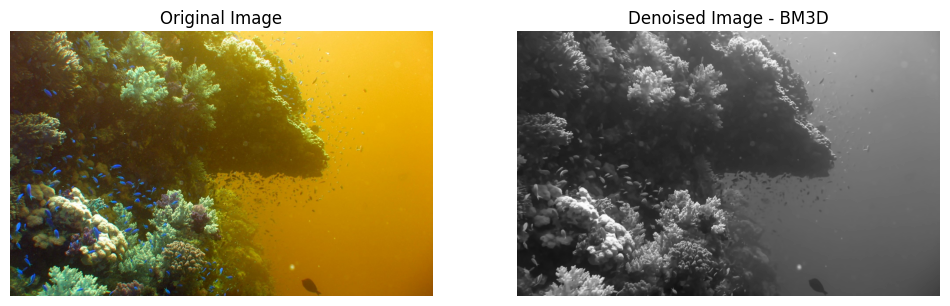

In [ ]:
display_images(image, denoised_image)

In [ ]:
calculate_snr(denoised_image)

2.0875501422022684

**Noise Estimation Methods**

1.   Mean Absolute Deviation (MAD)
2.   Difference of Gaussians



In [ ]:
import numpy as np
from skimage import filters
from PIL import Image

def estimate_noise_mad(image):
    # Convert the PIL Image to a NumPy array
    image_np = np.array(image)

    # Apply a high-pass filter to the image
    high_pass = filters.sobel(image_np) # Pass the NumPy array to sobel

    # Calculate the median absolute deviation
    mad = np.median(np.abs(high_pass - np.median(high_pass)))
    return mad

In [ ]:
# Upload the image
uploaded = files.upload()

# Load the image
image_path = list(uploaded.keys())[0]
noisy_img = Image.open(image_path)

Saving noisy image.png to noisy image.png


In [ ]:
estimate_noise_mad(noisy_img)

0.055055923692190936